## Neural Network Differential Equation for Hudgkin and Huxely Model

Importing required packages


In [5]:
import Pkg;

Pkg.activate(".")

  Activating project at `c:\Users\ahmed\OneDrive\Desktop\The Model\HodgkinModel.jl`


In [6]:
using HodgkinModel
using DiffEqFlux
using OrdinaryDiffEq
using Plots
using Flux

Initiating values of the HH Model 

In [7]:
#initial values of the invistigated bahavouirs 
u0 = -70.2 #initial voltage value 
n0 = 0.25 #initial Gating variable of K ion (The value represent the probability of this gate to be open)
m0 = 0.03 #initial Gating variable of Na ion 
h0 = 0.75 #initial Second Gating variable of Na ion 

x0=[u0,n0,m0,h0]

# time
T = 20 # ms
dt = 0.1 # ms
tspan = (0, T)

#Parameters of HH model
g_Na = 120 #mS/cm**2
g_K = 36   #mS/cm**2
g_L = 0.3  #mS/cm**2
E_Na = 55  #mV
E_K = -75  #mV
E_L = -69  #mV
C = 0.1    #µF/cm**2
I=-5

p=[g_Na,g_K,g_L,E_Na,E_K,E_L,C,I];


Steady state behaviour of the three gating variables n,m,m with changing of the implementing voltage   

In [8]:
#The equations calculated analytically from the gating variable differential equations in the HH Model

function steadyh(u)
        return alphah(u)/(alphah(u) + betah(u))
end 

function steadyn(u)
        return alphan(u)/(alphan(u) + betan(u))
end

function steadym(u)
    return alpham(u)/(alpham(u) + betam(u))  
end     

steadym (generic function with 1 method)

In [9]:
#applied voltage range 
u_range= -100:0.1:20;

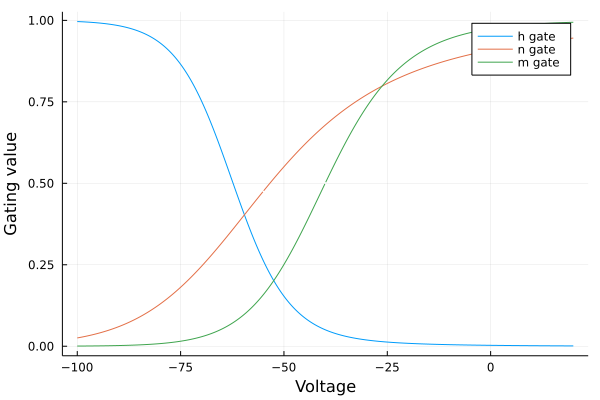

In [10]:
plot(u_range, steadyh.(u_range), xlabel="Voltage", ylabel="Gating value", label="h gate")
plot!(u_range, steadyn.(u_range),label="n gate")
plot!(u_range, steadym.(u_range),label="m gate")

Solving Hidgkin and Huxley Model Numerically

In [11]:
prob = ODEProblem(HHDifferentialEq, x0, tspan, p)
sol = solve(prob, Tsit5(), saveat=dt);

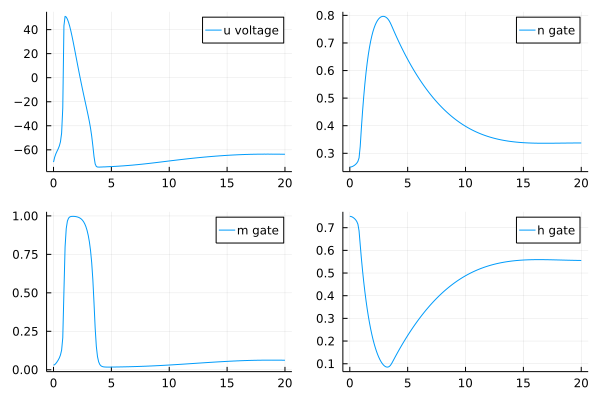

In [12]:
l = @layout [a ; b; c; d]

p1=plot(sol.t,sol[1,:],label="u voltage")
p2=plot(sol.t,sol[2,:],label="n gate")
p3=plot(sol.t,sol[3,:],label="m gate")
p4=plot(sol.t,sol[4,:],label="h gate")
plot(p1,p2,p3,p4)

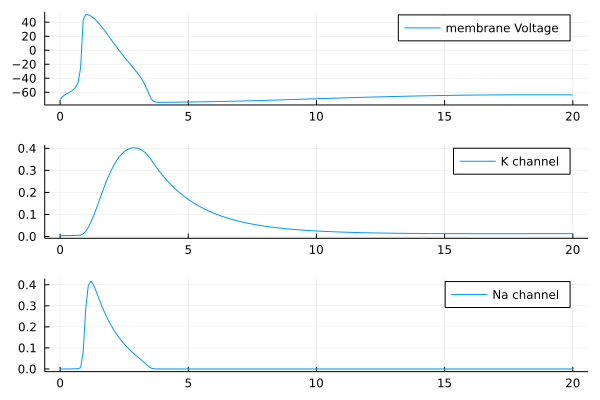

In [351]:
l = @layout [a ; b; c] 

p5=plot(sol.t,sol[1,:],label="membrane Voltage")
p6=plot(sol.t,sol[2,:].^4,label="K channel")
p7=plot(sol.t,sol[3,:].^3 .*sol[4,:],label="Na channel")
plot(p5,p6,p7,layout=l)

Creating Synthesized data for Neural Networks

In [319]:
train, valid = NODEDataloader(sol, 10; valid_set=0.6)


(NODEData{Float64,2} with 191 batches with length 10, NODEData{Float64,2} with 290 batches with length 10)

Construct the neural Network architecture  

In [320]:
N_WEIGHTS = 100
nn = Chain(Dense(4, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 4))
p, re_nn = Flux.destructure(nn)

(Float32[0.17619278, -0.19686584, -0.23186538, -0.20606942, -0.010980267, -0.09029013, 0.2145109, 0.21092762, 0.13716617, -0.039139993  …  -0.05858204, -0.016522327, -0.042753123, -0.118801355, 0.208187, -0.12899834, 0.0, 0.0, 0.0, 0.0], Restructure(Chain, ..., 31204))

Using NN Model to mimic the whole Differential equation of HH Model (data-driven approach Only)

In [321]:
neural_ode(u, p, t) = re_nn(p)(u)
node_prob = ODEProblem(neural_ode, x0, (Float32(0.),Float32(dt)), p)

ODEProblem with uType Vector{Float64} and tType Float32. In-place: false
timespan: (0.0f0, 0.1f0)
u0: 4-element Vector{Float64}:
 -70.2
   0.25
   0.03
   0.75

In [322]:
predict(t, u0) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p), Tsit5(), dt=dt, saveat = t))

predict (generic function with 1 method)

In [323]:
loss(t, u0) = sum(abs2, predict(t, view(u0,:,1)) - u0)
loss(train[1]...)

61773.00598706812

In [324]:
opt = Flux.AdamW(1f-5)


Flux.Optimise.Optimiser(Any[Adam(9.999999747378752e-6, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

In [325]:
TRAIN = true
if TRAIN 
    println("starting training...")
    for i_e = 1:400
        Flux.train!(loss, Flux.params(p), train, opt)
        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            opt[1].eta /= 2
        end
    end
end

starting training...


In [326]:
loss(train[1]...)

52634.17960400478

In [327]:
x=predict(1:0.1:20, x0)


4×191 Matrix{Float64}:
 -70.2   -69.3966    -68.5991     …  -13.2313   -13.1704   -13.1101
   0.25    0.234748    0.219978        2.90704    2.92736    2.94777
   0.03    0.021354    0.0118336      -9.35812   -9.41437   -9.47057
   0.75    0.742128    0.735151        7.905      7.91772    7.92992

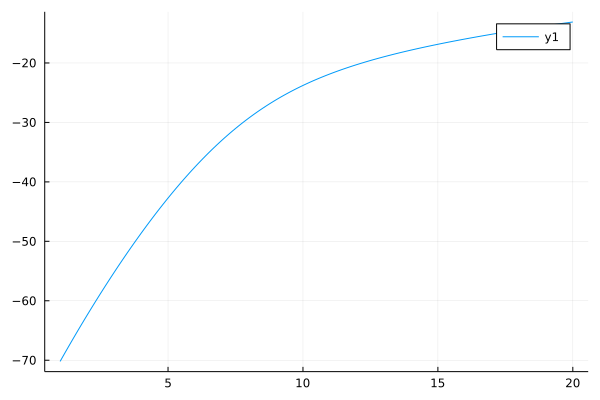

In [328]:
plot(1:0.1:20,x[1,:])

In [ ]:
using BSON: @save

@save "mymodel.bson" nn

4×100001 Matrix{Float64}:
 -70.2   -70.1966    -70.1931     …   836.569   836.606   836.644
   0.25    0.249203    0.248406      -208.116  -208.125  -208.134
   0.03    0.035317    0.0406333     1769.98   1770.06   1770.13
   0.75    0.749113    0.748226      -838.14   -838.176  -838.213

Modeling Just one Gate variable 

In [137]:
function NGATE(x,p,t)
    dn=alphan(x[2])*(1-x[1])-betan(x[2])*x[1]
    [dn,0]
end

NGATE (generic function with 1 method)

In [138]:
#initial conditions
n0 = 0.25
N0=[n0,0]


2-element Vector{Float64}:
 0.25
 0.0

In [139]:
prob = ODEProblem(NGATE, N0, tspan, p)
sol = solve(prob, Tsit5(), saveat=dt);


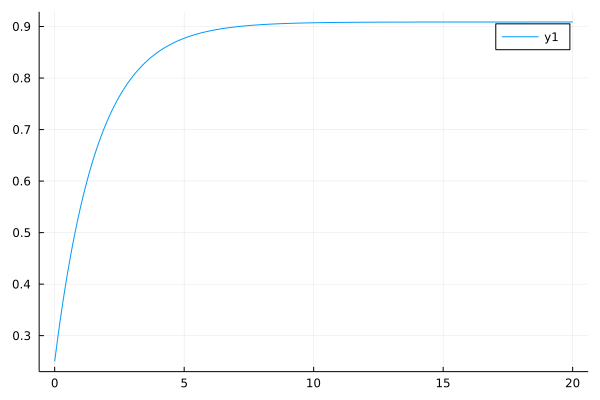

In [177]:
time=0:0.1:20
display(plot(time,sol[1,:]))

In [162]:
train, valid = NODEDataloader(sol, 10; valid_set=0.6)


(NODEData{Float64,2} with 71 batches with length 10, NODEData{Float64,2} with 110 batches with length 10)

In [165]:
N_WEIGHTS = 10 
nn = Chain(Dense(2, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 2)) |> gpu
p, re_nn = Flux.destructure(nn)

(Float32[0.01246257, -0.2092027, 0.47967505, -0.6667916, -0.08391243, -0.6921505, -0.053811662, -0.012752709, 0.5897329, -0.00785651  …  0.07487463, -0.7017174, -0.25379315, 0.24622871, 0.55450237, -0.6868023, 0.38226467, -0.66133875, 0.0, 0.0], Restructure(Chain, ..., 272))

In [166]:
neural_ode(u, p, t) = re_nn(p)(u)
node_prob = ODEProblem(neural_ode, N0, (Float32(0.),Float32(dt)), p)

ODEProblem with uType Vector{Float64} and tType Float32. In-place: false
timespan: (0.0f0, 0.1f0)
u0: 2-element Vector{Float64}:
 0.25
 0.0

In [167]:
opt = Flux.AdamW(1f-4)


Flux.Optimise.Optimiser(Any[Adam(9.999999747378752e-5, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

In [168]:
predict(t, u0) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p), Tsit5(), dt=dt, saveat = t))

predict (generic function with 1 method)

In [169]:
loss(t, u0) = sum(abs2, predict(t, view(u0,:,1)) - u0)
loss(train[1]...)

0.2783993171660881

In [170]:
TRAIN = true
if TRAIN 
    println("starting training...")
    for i_e = 1:400
        Flux.train!(loss, Flux.params(p), train, opt)
        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            opt[1].eta /= 2
        end
    end
end

starting training...


In [171]:
loss(train[1]...)

0.014986586578060663

In [178]:
x=predict(0:0.1:20, N0)

2×201 Matrix{Float64}:
 0.25   0.27788      0.305041    …  0.870493   0.869501  0.868509
 0.0   -0.00224021  -0.00438086     0.0644144  0.065109  0.0658033

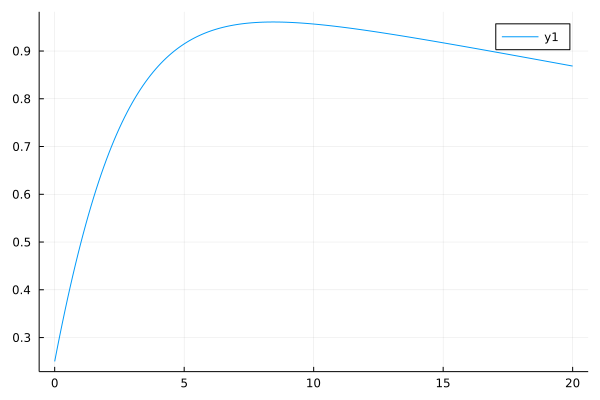

In [179]:
plot(0:0.1:20,x[1,:])

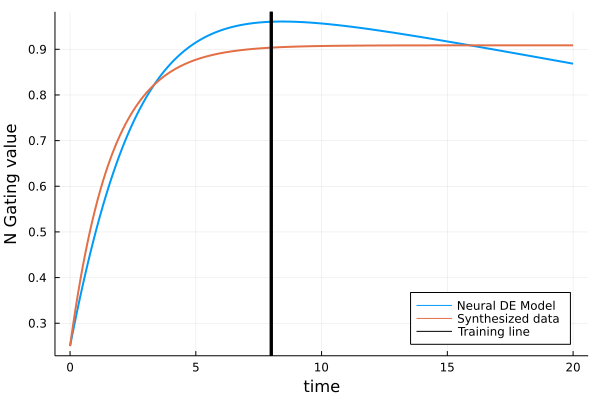

In [212]:
plot(0:0.1:20, x[1,:], xlabel="time", ylabel="N Gating value", label="Neural DE Model",legend=:bottomright,linewidth = 2)
plot!(0:0.1:20, sol[1,:],label="Synthesized data",linewidth = 2)
vline!([8,8],label="Training line",linewidth = 3,color="Black")




Differential Neural Network for HH Model (Physics-Informed Machine learning) - Replacing all three gates as three different neural network models

In [221]:
#initial conditions
u0 = -70.2
m0 = 0.03
n0 = 0.25
h0 = 0.75

x0=[u0,n0,m0,h0]

# time
T = 50 # ms
dt = 0.01 # ms
tspan = (0, T)

p=[g_Na,g_K,g_L,E_Na,E_K,E_L,C,I];

8-element Vector{Float64}:
 120.0
  36.0
   0.3
  55.0
 -75.0
 -69.0
   0.1
  -9.0

In [223]:
prob = ODEProblem(HHDifferentialEq, x0, tspan, p)
sol = solve(prob, Tsit5(), saveat=dt);

In [224]:
train, valid = NODEDataloader(sol, 10; dt=dt, valid_set=0.6)


(NODEData{Float64,2} with 1991 batches with length 10, NODEData{Float64,2} with 2990 batches with length 10)

In [240]:
N_WEIGHTS = 10 
re2 = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p2, re_nn2 = Flux.destructure(re2)

(Float32[-0.35822168, 0.56939495, 0.51217586, -0.6268299, -0.46786845, 0.5572845, -0.36082667, 0.09933609, 0.09424462, -0.6014458  …  0.54525524, -0.22131576, -0.25690088, -0.54909027, -0.49122086, -0.48303154, 0.64965, -0.1346982, -0.44800884, 0.0], Restructure(Chain, ..., 251))

In [241]:
N_WEIGHTS = 10 
re3 = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p3, re_nn3 = Flux.destructure(re3)

(Float32[0.16809954, -0.3612025, -0.39359048, 0.19353738, -0.7121302, 0.58958215, 0.58674884, -0.6311104, 0.10366484, 0.69617325  …  -0.35068047, -0.6437157, 0.107238196, 0.45377964, 0.30506682, -0.24097428, -0.020776743, 0.58562106, -0.23925833, 0.0], Restructure(Chain, ..., 251))

In [242]:
N_WEIGHTS = 10 
re4 = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p4, re_nn4 = Flux.destructure(re4)

(Float32[0.05824966, -0.65940726, -0.66599804, 0.11257459, -0.041206863, 0.6753709, -0.29477385, -0.16689758, 0.06907415, 0.5819696  …  -0.5465739, 0.68231744, 0.3843366, -0.6120576, 0.44896162, -0.597608, 0.28043386, -0.17311765, 0.4814997, 0.0], Restructure(Chain, ..., 251))

In [260]:
function node_ks2(u,p2,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-9))/0.1
    dn=re_nn2(p2)([u[2]])
    dm=re_nn3(p3)([u[3]])
    dh=re_nn4(p4)([u[4]])
    [du,dn[1],dm[1],dh[1]]

end


function node_ks3(u,p3,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-9))/0.1
    dn=re_nn2(p2)([u[2]])
    dm=re_nn3(p3)([u[3]])
    dh=re_nn4(p4)([u[4]])
    [du,dn[1],dm[1],dh[1]]

end

function node_ks4(u,p4,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-9))/0.1
    dn=re_nn2(p2)([u[2]])
    dm=re_nn3(p3)([u[3]])
    dh=re_nn4(p4)([u[4]])
    [du,dn[1],dm[1],dh[1]]

end



node_prob2 = ODEProblem(node_ks2, x0, (Float32(0.),Float32(dt)), p2)
node_prob3 = ODEProblem(node_ks3, x0, (Float32(0.),Float32(dt)), p3)
node_prob4 = ODEProblem(node_ks4, x0, (Float32(0.),Float32(dt)), p4)


ODEProblem with uType Vector{Float64} and tType Float32. In-place: false
timespan: (0.0f0, 0.01f0)
u0: 4-element Vector{Float64}:
 -70.2
   0.25
   0.03
   0.75

In [261]:
predict2(t, u0) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p2), Tsit5(), dt=dt, saveat = t))
predict3(t, u0) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p3), Tsit5(), dt=dt, saveat = t))
predict4(t, u0) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p4), Tsit5(), dt=dt, saveat = t))

predict4 (generic function with 1 method)

In [263]:
loss(t, u0) = sum(abs2, predict2(t, view(u0,:,1)) - u0)+sum(abs2, predict3(t, view(u0,:,1)) - u0)+sum(abs2, predict4(t, view(u0,:,1)) - u0)
loss(train[1]...)

0.005832911888290973

In [264]:
opt = Flux.AdamW(1f-3)

Flux.Optimise.Optimiser(Any[Adam(0.0010000000474974513, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

In [265]:
TRAIN = true
if TRAIN 
    println("starting training...")
    for i_e = 1:4
        Flux.train!(loss, Flux.params(p2), train, opt)
        Flux.train!(loss, Flux.params(p3), train, opt)
        Flux.train!(loss, Flux.params(p4), train, opt)

        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            opt[1].eta /= 2
        end
    end
end

In [ ]:
loss(train[1]...)

In [ ]:
x=predict(train.t, x0)
plot(train.t,x[1,:])

Differential Neural Network for HH Model (Physics-Informed Machine learning) - replacing one gate with neural network model

In [251]:
#initial conditions
u0 = -70.2
m0 = 0.03
n0 = 0.25
h0 = 0.75

x0=[u0,n0,m0,h0]

# time
T = 20 # ms
dt = 0.01 # ms
tspan = (0, T)

g_Na = 120 #mS/cm**2
g_K = 36   #mS/cm**2
g_L = 0.3  #mS/cm**2
E_Na = 55  #mV
E_K = -75  #mV
E_L = -69  #mV
C = 0.1    #µF/cm**2
I=-5

p=[g_Na,g_K,g_L,E_Na,E_K,E_L,C,I]

8-element Vector{Float64}:
 120.0
  36.0
   0.3
  55.0
 -75.0
 -69.0
   0.1
  -5.0

In [252]:
prob = ODEProblem(HHDifferentialEq, x0, tspan, p)
sol = solve(prob, Tsit5(), saveat=dt);

In [253]:
train, valid = NODEDataloader(sol, 10;  valid_set=0.6)


(NODEData{Float64,2} with 791 batches with length 10, NODEData{Float64,2} with 1190 batches with length 10)

In [283]:
N_WEIGHTS = 10
re = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p, re_nn = Flux.destructure(re)

(Float32[-0.5010739, 0.010828096, 0.37465972, -0.25523353, 0.6572747, -0.13956806, 0.06682195, -0.549548, 0.20244591, -0.09610055  …  0.60862017, -0.08398413, -0.2907777, -0.6414457, 0.19833946, -0.47573745, -0.5682748, -0.23041101, -0.4389877, 0.0], Restructure(Chain, ..., 251))

In [ ]:
#loaded
@load "Ngate.bson" re
p, re_nn = Flux.destructure(re)


In [284]:
function node_ksONE(u,p,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-5))/0.1
    dn=re_nn(p)([u[2]])
    dm=alpham(u[1])*(1-u[3])-betam(u[1])*u[3]
    dh=alphah(u[1])*(1-u[4])-betah(u[1])*u[4]
    [du,dn[1],dm,dh]

end

node_prob = ODEProblem(node_ksONE, x0, (Float32(0.),Float32(dt)), p)

ODEProblem with uType Vector{Float64} and tType Float32. In-place: false
timespan: (0.0f0, 0.01f0)
u0: 4-element Vector{Float64}:
 -70.2
   0.25
   0.03
   0.75

In [285]:
predict(t, u0; reltol=1e-5) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p), Tsit5(), dt=dt, saveat = t, reltol=reltol))

predict (generic function with 1 method)

In [286]:
loss(t, u0) = sum(abs2, predict(t, view(u0,:,1)) - u0)
loss(train[1]...)

0.0009640647076209765

In [287]:
opt = Flux.AdamW(1f-5)

Flux.Optimise.Optimiser(Any[Adam(9.999999747378752e-6, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

In [288]:
TRAIN = true
if TRAIN 
    println("starting training...")
    for i_e = 1:50
        Flux.train!(loss, Flux.params(p), train, opt)
        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            opt[1].eta /= 2
        end
    end
end

starting training...


In [289]:
loss(train[1]...)

0.0014663019040165287

In [290]:
x=predict(0:0.1:20, x0)


4×201 Matrix{Float64}:
 -70.2   -66.1769     -63.5193     -61.5734     …  -74.9948     -74.9951
   0.25    0.254339     0.258711     0.263115        2.47459      2.49912
   0.03    0.0329287    0.0404754    0.0500763       0.0154022    0.0154017
   0.75    0.74937      0.747472     0.744557        0.735751     0.737465

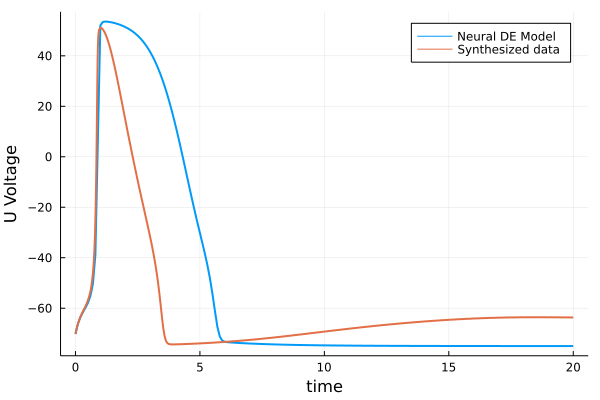

In [294]:
plot(0:0.1:20, x[1,:], xlabel="time", ylabel="U Voltage", label="Neural DE Model",linewidth = 2)
plot!(0:0.01:20, sol[1,:],label="Synthesized data",linewidth = 2)


In [61]:
using BSON: @save

@save "Ngate.bson" re

Different way to try to replace the n gating equation with a pre-knowledge of its behavouir  



In [172]:
using Flux, DiffEqFlux 
N_WEIGHTS = 10
re = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p, re_nn = Flux.destructure(re)

(Float32[0.619301, -0.09136794, -0.22454178, 0.15586337, 0.0022289567, -0.21934018, -0.35495323, 0.59895676, 0.32105735, -0.11865265  …  0.5009736, 0.35744086, -0.30834174, -0.3739176, 0.45976543, -0.14658104, 0.23382501, 0.2643736, -0.67243034, 0.0], Restructure(Chain, ..., 251))

In [94]:
function node_Ngate(u,p,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-9))/0.1
    dn=(0.5*(1-u[2])-0.5*(u[2])).+re_nn(p)([u[2]])
    dm=alpham(u[1])*(1-u[3])-betam(u[1])*u[3]
    dh=alphah(u[1])*(1-u[4])-betah(u[1])*u[4]
    [du,dn[1],dm,dh]

end

node_prob = ODEProblem(node_Ngate, x0, (Float32(0.),Float32(dt)), p)

ODEProblem with uType Vector{Float64} and tType Float32. In-place: false
timespan: (0.0f0, 0.01f0)
u0: 4-element Vector{Float64}:
 -70.2
   0.25
   0.03
   0.75

In [95]:
predict(t, u0; reltol=1e-5) = Array(solve(remake(node_prob; tspan=(t[1],t[end]),u0=u0, p=p), Tsit5(), dt=dt, saveat = t, reltol=reltol))

predict (generic function with 1 method)

In [96]:
loss(t, u0) = sum(abs2, predict(t, view(u0,:,1)) - u0)
loss(train[1]...)

0.08631620106423345

In [97]:
opt = Flux.AdamW(1f-3)

Flux.Optimise.Optimiser(Any[Adam(0.0010000000474974513, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), WeightDecay(0)])

In [105]:
TRAIN = true
if TRAIN 
    println("starting training...")
    for i_e = 1:100
        Flux.train!(loss, Flux.params(p), train, opt)
        if (i_e % 30) == 0  # reduce the learning rate every 30 epochs
            opt[1].eta /= 2
        end
    end
end

starting training...


In [106]:
loss(train[1]...)

0.10984823376023581

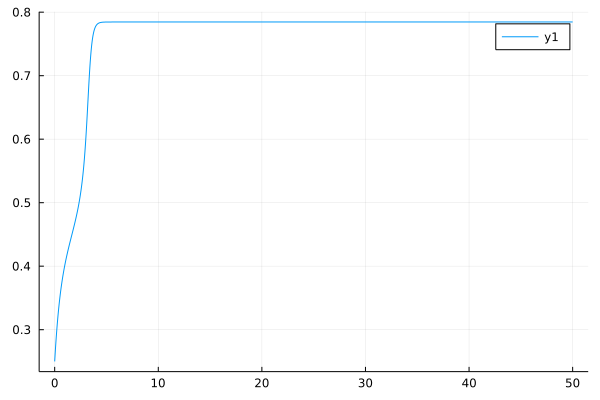

In [108]:
x=predict(0:0.01:50, x0)
plot(0:0.01:50,x[2,:])

GATE M

In [ ]:
using Flux, DiffEqFlux 
N_WEIGHTS = 10
re = Chain(Dense(1, N_WEIGHTS, swish), Dense(N_WEIGHTS, N_WEIGHTS, swish),Dense(N_WEIGHTS, N_WEIGHTS, swish), Dense(N_WEIGHTS, 1),x->reshape(x,:)) |> gpu
p, re_nn = Flux.destructure(re)

In [ ]:
function node_Mgate(u,p,t)
    du=(120*(u[3])^3*u[4]*(55-u[1])+36*(u[2])^4*(-75-u[1])+0.3*(-69-u[1])-(-9))/0.1
    dn=alphan(x[1])*(1-x[2])-betan(x[1])*x[2]
    dm=re_nn(p)([u[3]])
    dh=alphah(u[1])*(1-u[4])-betah(u[1])*u[4]
    [du,dn,dm[1],dh]

end

node_prob = ODEProblem(node_Ngate, x0, (Float32(0.),Float32(dt)), p)